<a href="https://colab.research.google.com/github/knysmchr/first-git/blob/main/Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#目的

使用率が高いポケモンからどのような傾向があるか知りたい。

#仮説

「とくこう」「すばやさ」が高いポケモンが使用率が高いのではないか。

#データの前処理

In [45]:
data = pd.read_csv('/content/drive/MyDrive/Pokemon.csv')

In [46]:
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [47]:
data = data.rename(columns = {'#':'PBN'})

使用率を知るためにポケモンデータベースから情報を得る。また、上記のデータベースがポケモン名英語のため橋渡しとなる情報も得る。

In [48]:
import urllib.request as request
import requests
from bs4 import BeautifulSoup

In [49]:
# 使用率の高い順に並んだポケモンのDataFrameを作成
# URL定義
url = 'https://swsh.pokedb.tokyo/pokemon/list?season=18&rule=0'

# HTML取得
response = request.urlopen(url)
bs = BeautifulSoup(response, 'html.parser')

# 順位で並んだポケモンの要素を取り出す
pokemon = bs.select('.pokemon-ranking-name')

# リストを定義
pokemon_list = []

# ポケモンの要素をリストに挿入
for i,p in enumerate(pokemon):
  pokemon_list.append(pokemon[i].text.replace('\n                                ','').replace('                            ',''))
# 重複があったため重複解消
pokemon_list = sorted(set(pokemon_list), key = pokemon_list.index)

# DataFrameに変換
pokemon_dict = {'Name_ja':pokemon_list,'Freq_of_use':[i+1 for i in range(len(pokemon_list))]}
order = pd.DataFrame(pokemon_dict)

In [50]:
order.head(10)

,Name_ja,Freq_of_use
0,サンダー,1
1,エースバーン,2
2,ミミッキュ,3
3,ポリゴン２,4
4,カプ・レヒレ,5
5,ランドロス,6
6,ウーラオス,7
7,ドラパルト,8
8,ウオノラゴン,9
9,カイリュー,10


In [51]:
# 日英変換のためのDataFrameを作成
# URL定義
pokemon_url = "https://wiki.ポケモン.com/wiki/ポケモンの外国語名一覧"

# HTML取得
r = requests.get(pokemon_url)
soup = BeautifulSoup(r.content, "html.parser")

# リストを定義　*ここに各行のデータを加えていく
rows = []

# 各行を処理する
for tr in soup.find("div", {"id": "mw-content-text"}).findAll("tr"):
    # thタグがあればTableのコラムとしてデータを取得
    if tr.find("th"):
        columns = [x.getText().strip() for x in tr.findAll("th")]

    # tdタグがあればリストに挿入
    if tr.find("td"):
        rows.append([x.getText().strip() for x in tr.findAll("td")])

# DataFrameに変換する
df = pd.DataFrame(rows, columns=columns)

# 不要な列を削除
df_new = df.drop(columns = ['番号', 'ドイツ語', 'フランス語', '韓国語', '中国語（簡）', '中国語（繁）'])

# columns名を変更
df_new = df_new.rename(columns = {'日本語':'Name_ja', '英語':'Name'})

In [52]:
df_new

,Name_ja,Name
0,フシギダネ,Bulbasaur
1,フシギソウ,Ivysaur
2,フシギバナ,Venusaur
3,ヒトカゲ,Charmander
4,リザード,Charmeleon
...,...,...
893,レジエレキ,Regieleki
894,レジドラゴ,Regidrago
895,ブリザポス,Glastrier
896,レイスポス,Spectrier


DataFrame結合

In [53]:
data2 = data.merge(df_new, on = 'Name')
data2 = data2.merge(order, on = 'Name_ja')
data2 = data2.reindex(columns=['PBN', 'Name', 'Name_ja',
       'Freq_of_use', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'])
data2_d=data2.sort_values('Freq_of_use').reset_index(drop=True).drop(columns=['Freq_of_use','Generation','Legendary'])

In [54]:
data2_d

,PBN,Name,Name_ja,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,145,Zapdos,サンダー,Electric,Flying,580,90,90,85,125,90,100
1,149,Dragonite,カイリュー,Dragon,Flying,600,91,134,95,100,100,80
2,445,Garchomp,ガブリアス,Dragon,Ground,600,108,130,95,80,85,102
3,450,Hippowdon,カバルドン,Ground,NaN,525,108,112,118,68,72,47
4,598,Ferrothorn,ナットレイ,Grass,Steel,489,74,94,131,54,116,20
...,...,...,...,...,...,...,...,...,...,...,...,...
440,708,Phantump,ボクレー,Ghost,Grass,309,43,70,48,50,60,38
441,709,Trevenant,オーロット,Ghost,Grass,474,85,110,76,65,82,56
442,712,Bergmite,カチコール,Ice,NaN,304,55,69,85,32,35,28
443,714,Noibat,オンバット,Flying,Dragon,245,40,30,35,45,40,55


使用頻度の降順とする(使用率の高い順に並んだポケモンのDataFrameと日英変換用のDataFrameのモンスター数が異なるため番号は歯抜けだが今回は無視。一度、降順とし、Freq_of_useを削除。再度Freq_of_useを割振) 

In [55]:
data3 = pd.concat([data2_d,pd.DataFrame({'Freq_Of_Use':[i+1 for i in range(len(data2_d))]})],axis=1)
data3[data3['Freq_Of_Use']<=30]

,PBN,Name,Name_ja,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Freq_Of_Use
0,145,Zapdos,サンダー,Electric,Flying,580,90,90,85,125,90,100,1
1,149,Dragonite,カイリュー,Dragon,Flying,600,91,134,95,100,100,80,2
2,445,Garchomp,ガブリアス,Dragon,Ground,600,108,130,95,80,85,102,3
3,450,Hippowdon,カバルドン,Ground,NaN,525,108,112,118,68,72,47,4
4,598,Ferrothorn,ナットレイ,Grass,Steel,489,74,94,131,54,116,20,5
5,248,Tyranitar,バンギラス,Rock,Dark,600,100,134,110,95,100,61,6
6,260,Swampert,ラグラージ,Water,Ground,535,100,110,90,85,90,60,7
7,464,Rhyperior,ドサイドン,Ground,Rock,535,115,140,130,55,55,40,8
8,530,Excadrill,ドリュウズ,Ground,Steel,508,110,135,60,50,65,88,9
9,131,Lapras,ラプラス,Water,Ice,535,130,85,80,85,95,60,10


列名

'PBN':ポケモン図鑑番号

'Name':ポケモン名(英語)

'Name_ja':ポケモン名(日本語)

'Freq_of_use':使用頻度ランク

'Type 1':タイプ1

'Type 2':タイプ2

'Total':ステータス総合値

'HP':ヒットポイント

'Attack':こうげき

'Defense':ぼうぎょ

'Sp. Atk':とくこう

'Sp. Def':とくぼう

'Speed':すばやさ

#データの可視化

In [56]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PBN          445 non-null    int64 
 1   Name         445 non-null    object
 2   Name_ja      445 non-null    object
 3   Type 1       445 non-null    object
 4   Type 2       230 non-null    object
 5   Total        445 non-null    int64 
 6   HP           445 non-null    int64 
 7   Attack       445 non-null    int64 
 8   Defense      445 non-null    int64 
 9   Sp. Atk      445 non-null    int64 
 10  Sp. Def      445 non-null    int64 
 11  Speed        445 non-null    int64 
 12  Freq_Of_Use  445 non-null    int64 
dtypes: int64(9), object(4)
memory usage: 45.3+ KB


In [57]:
data3.describe()

,PBN,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Freq_Of_Use
count,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
mean,359.121348,420.541573,69.053933,74.757303,73.085393,68.498876,70.714607,64.431461,223.000000
std,215.623752,101.811282,27.571639,29.081579,30.959242,27.354745,27.271192,27.399249,128.604691
min,1.000000,190.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000
25%,149.000000,328.000000,50.000000,53.000000,50.000000,50.000000,50.000000,45.000000,112.000000
50%,359.000000,442.000000,65.000000,75.000000,70.000000,65.000000,66.000000,60.000000,223.000000
75%,560.000000,500.000000,80.000000,95.000000,90.000000,90.000000,85.000000,84.000000,334.000000
max,715.000000,670.000000,255.000000,160.000000,230.000000,145.000000,230.000000,160.000000,445.000000


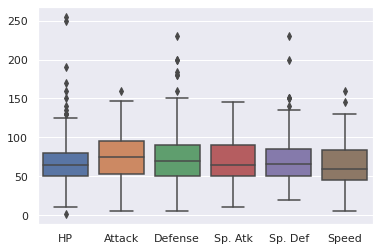

In [58]:
sns.boxplot(data = data3[['HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed']])

Freq_Of_Useが30以下の時、使用率が高いと定義

In [59]:
data3['High_Rate'] = 0
for i in range(len(data3)):
  if data3['Freq_Of_Use'][i] <= 30:
    data3['High_Rate'][i] = 1
data3.head(40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,PBN,Name,Name_ja,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Freq_Of_Use,High_Rate
0,145,Zapdos,サンダー,Electric,Flying,580,90,90,85,125,90,100,1,1
1,149,Dragonite,カイリュー,Dragon,Flying,600,91,134,95,100,100,80,2,1
2,445,Garchomp,ガブリアス,Dragon,Ground,600,108,130,95,80,85,102,3,1
3,450,Hippowdon,カバルドン,Ground,NaN,525,108,112,118,68,72,47,4,1
4,598,Ferrothorn,ナットレイ,Grass,Steel,489,74,94,131,54,116,20,5,1
5,248,Tyranitar,バンギラス,Rock,Dark,600,100,134,110,95,100,61,6,1
6,260,Swampert,ラグラージ,Water,Ground,535,100,110,90,85,90,60,7,1
7,464,Rhyperior,ドサイドン,Ground,Rock,535,115,140,130,55,55,40,8,1
8,530,Excadrill,ドリュウズ,Ground,Steel,508,110,135,60,50,65,88,9,1
9,131,Lapras,ラプラス,Water,Ice,535,130,85,80,85,95,60,10,1


In [60]:
data3[data3['High_Rate'] == 1].describe()

,PBN,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Freq_Of_Use,High_Rate
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0
mean,311.033333,536.133333,96.100000,95.366667,91.900000,88.966667,88.700000,75.100000,15.500000,1.0
std,197.895215,50.313317,34.677181,33.717368,30.263612,25.501161,20.020937,21.857454,8.803408,0.0
min,6.000000,420.000000,50.000000,5.000000,5.000000,35.000000,45.000000,20.000000,1.000000,1.0
25%,134.500000,512.250000,80.000000,70.000000,78.250000,71.250000,77.750000,60.000000,8.250000,1.0
50%,316.500000,535.000000,93.000000,94.500000,85.000000,90.000000,90.000000,80.000000,15.500000,1.0
75%,471.750000,580.000000,106.000000,128.750000,109.000000,109.750000,100.000000,90.750000,22.750000,1.0
max,700.000000,600.000000,250.000000,140.000000,180.000000,130.000000,130.000000,116.000000,30.000000,1.0


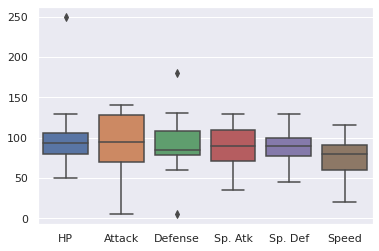

In [61]:
sns.boxplot(data=data3[data3['High_Rate'] == 1][['HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed']])

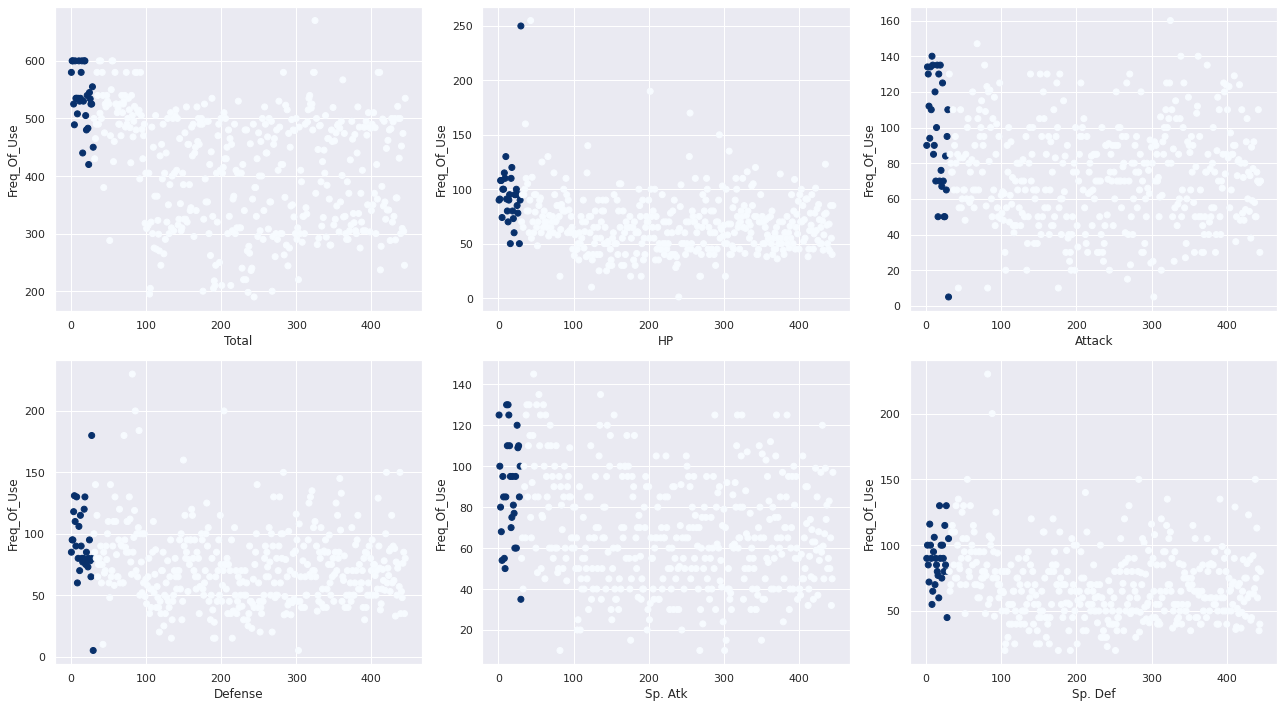

(-0.21137321613056204, 6.88234141677502e-06)

In [77]:
rows=2
cols=3
fig,axes=plt.subplots(rows,cols,figsize=(cols*6,rows*5))
li=['Total','HP', 'Attack', 'Defense','Sp. Atk', 'Sp. Def', 'Speed']
for r in range(0,rows):
  for c in range(0,cols):
    i=r*cols+c
    if i < len(li):
      axes[r][c].scatter(x='Freq_Of_Use',y=li[i],data=data3,c='High_Rate',cmap='Blues')
      axes[r][c].set_xlabel(li[i])
      axes[r][c].set_ylabel('Freq_Of_Use')
plt.tight_layout()
plt.show()

今回は「とくこう」と「すばやさ」に着目しているため相関確認

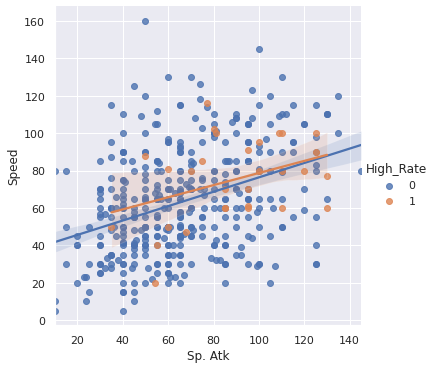

In [63]:
sns.lmplot(x='Sp. Atk',y='Speed',data=data3,hue='High_Rate')
plt.xlabel('Sp. Atk')
plt.ylabel('Speed')
plt.show()

#分析

検証時「とくこう」、「すばやさ」が数値のままだと分析しにくいためグループを作成。

帰無仮説:使用率は「とくこう」、「すばやさ」に影響されない。

対立仮説:使用率は「とくこう」、「すばやさ」に影響される。

In [64]:
bins_total_edges=[-float('inf'),328,442,500,float('inf')]
bins_hp_edges=[-float('inf'),50,65,80,float('inf')]
bins_attack_edges=[-float('inf'),53,75,95,float('inf')]
bins_defense_edges=[-float('inf'),50,70,90,float('inf')]
bins_sp_atk_edges=[-float('inf'),50,65,90,float('inf')]
bins_sp_def_edges=[-float('inf'),50,66,85,float('inf')]
bins_speed_edges=[-float('inf'),45,60,84,float('inf')]
binned_total=pd.cut(data3['Total'],bins_total_edges,labels=False)
binned_hp=pd.cut(data3['HP'],bins_hp_edges,labels=False)
binned_attack=pd.cut(data3['Attack'],bins_attack_edges,labels=False)
binned_defense=pd.cut(data3['Defense'],bins_defense_edges,labels=False)
binned_sp_atk=pd.cut(data3['Sp. Atk'],bins_sp_atk_edges,labels=False)
binned_sp_def=pd.cut(data3['Sp. Def'],bins_sp_def_edges,labels=False)
binned_speed=pd.cut(data3['Speed'],bins_speed_edges,labels=False)
data3_2=pd.concat([data3,pd.DataFrame({'binned_total':binned_total,'binned_hp':binned_hp,'binned_attack':binned_attack,'binned_defense':binned_defense,'binned_sp_atk':binned_sp_atk,'binned_sp_def':binned_sp_def,'binned_speed':binned_speed})],axis=1)

In [65]:
data3_2

,PBN,Name,Name_ja,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Freq_Of_Use,High_Rate,binned_total,binned_hp,binned_attack,binned_defense,binned_sp_atk,binned_sp_def,binned_speed
0,145,Zapdos,サンダー,Electric,Flying,580,90,90,85,125,90,100,1,1,3,3,2,2,3,3,3
1,149,Dragonite,カイリュー,Dragon,Flying,600,91,134,95,100,100,80,2,1,3,3,3,3,3,3,2
2,445,Garchomp,ガブリアス,Dragon,Ground,600,108,130,95,80,85,102,3,1,3,3,3,3,2,2,3
3,450,Hippowdon,カバルドン,Ground,NaN,525,108,112,118,68,72,47,4,1,3,3,3,3,2,2,1
4,598,Ferrothorn,ナットレイ,Grass,Steel,489,74,94,131,54,116,20,5,1,2,2,2,3,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,708,Phantump,ボクレー,Ghost,Grass,309,43,70,48,50,60,38,441,0,0,0,1,0,0,1,0
441,709,Trevenant,オーロット,Ghost,Grass,474,85,110,76,65,82,56,442,0,2,3,3,2,1,2,1
442,712,Bergmite,カチコール,Ice,NaN,304,55,69,85,32,35,28,443,0,0,1,1,2,0,0,0
443,714,Noibat,オンバット,Flying,Dragon,245,40,30,35,45,40,55,444,0,0,0,0,0,0,0,1


In [66]:
model=smf.ols('Freq_Of_Use ~ binned_total + binned_hp + binned_attack + binned_defense + binned_sp_atk + binned_sp_def +  binned_speed', data = data3).fit()
sm.stats.anova_lm(model,typ=2)

,sum_sq,df,F,PR(>F)
binned_total,1.708818e+05,1.0,11.618529,0.000714
binned_hp,2.728974e+01,1.0,0.001855,0.965661
binned_attack,1.358462e+05,1.0,9.236405,0.002515
binned_defense,3.101849e+04,1.0,2.108998,0.147153
binned_sp_atk,1.074310e+03,1.0,0.073044,0.787083
binned_sp_def,4.782107e+03,1.0,0.325143,0.568826
binned_speed,5.596855e+04,1.0,3.805393,0.051727
Residual,6.427262e+06,437.0,NaN,NaN


#結果

「とくこう」、「すばやさ」のp値はいずれも0.05より大きいため、使用率は「とくこう」、「すばやさ」の2項目からの影響は受けないという結論に至った。
単体の数値の高低の影響というより、総合値の高低やモンスターのタイプに大きく影響されていると考えられる。そのため、次回解析する場合は総合値、モンスターのタイプに焦点を当てた分析が必要。